# Initialization

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from result_saver import SaverProvider

provider = SaverProvider()

In [7]:
from Scratch import load_calibration_memory

DEVICE = 'ibm_sherbrooke'

all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date='2023-10-30')

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


# Fitting mmr_0 and mmr_1

In [419]:
import numpy as np
from sklearn.mixture import GaussianMixture

print(all_memories[0].keys())
print(all_memories[0]['mmr_0'].shape)

qubit = 12
IQ_data = all_memories[qubit]['mmr_1']
data = IQ_data.flatten()
combined_data = np.column_stack((data.real, data.imag))

dict_keys(['mmr_0', 'mmr_1'])
(10000,)


In [420]:
# Define the range of components to try

n_components_range = range(1, 4)  # Adjust this range as needed

lowest_bic = np.infty
best_gmm = None

for n_components in n_components_range:

    weights_init = [1]

    # Distribute the remaining weight equally among other components
    if n_components > 1:
        # Initialize weights
        weights_init = np.zeros(n_components)
        primary_weight = 0.95  # Weight for the first component
        weights_init = np.zeros(n_components)
        weights_init[0] = primary_weight
        remaining_weight = (1 - primary_weight) / (n_components-1)
        for i in range(1, n_components):
            weights_init[i] = remaining_weight

    if n_components == 2:
        means_init = np.array([[-1e8, 0], [1e8, 0]])
        # means_init = None
    else:
        means_init = None

    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, init_params='random',
                          covariance_type='tied', random_state=0, weights_init=weights_init, means_init=means_init)
    gmm.fit(combined_data)
    
    # Calculate BIC
    bic = gmm.bic(combined_data)
    
    # Check if this is the lowest BIC so far
    if bic < lowest_bic and np.all([weight < 0.1 or weight > 0.9 for weight in gmm.weights_]):
        lowest_bic = bic
        best_gmm = gmm

# best_gmm is now the model with the lowest BIC
print("Best number of components:", best_gmm.n_components)
gmm = best_gmm
print("means: ", gmm.means_)
print("covariances: ", gmm.covariances_)
gmm.covariances_ = np.array([gmm.covariances_, gmm.covariances_])
# print("covariances: ", gmm.covariances_)

print("weights: ", gmm.weights_)


Best number of components: 2
means:  [[ -444630.33550532 -1396963.86674155]
 [ 1559501.00491123 -2078659.48215187]]
covariances:  [[ 5.81030036e+11 -9.24336328e+10]
 [-9.24336328e+10  8.42171157e+11]]
weights:  [0.06306913 0.93693087]


# Plot the data + fitting

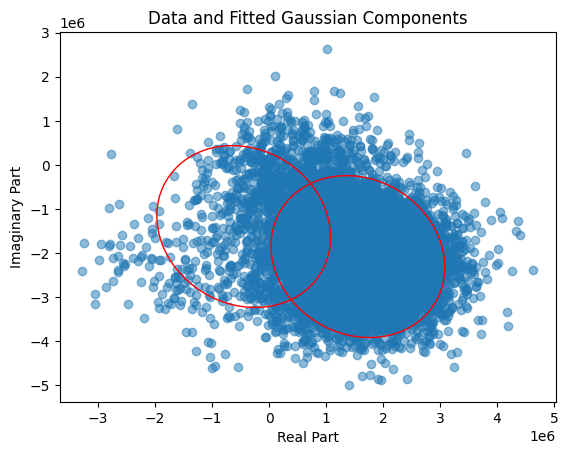

In [421]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

data_2d = combined_data

# Assuming data_2d is your dataset and gmm is your fitted GaussianMixture model
# Plot the data points
plt.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5)

def draw_ellipse(mean, cov, n_std=1, ax=None, **kwargs):
    """Draw an ellipse with a given mean and covariance"""
    ax = ax or plt.gca()

    # Eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellipse)

# Number of standard deviations to draw
n_std = 2 

# Plot each Gaussian component
for mean, covar in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(mean, covar, n_std=n_std, alpha=1, edgecolor='red', facecolor='none')

# draw_ellipse(mean_est, cov_est, n_std=n_std, alpha=1, edgecolor='green', facecolor='none')

plt.title("Data and Fitted Gaussian Components")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.show()

# Tied cov matrices

In [322]:

# Define the range of components to try

n_components_range = range(2, 3)  # Adjust this range as needed

lowest_bic = np.infty
best_gmm = None

for n_components in n_components_range:

    weights_init = [1]

    # Distribute the remaining weight equally among other components
    if n_components > 1:
        # Initialize weights
        weights_init = np.zeros(n_components)
        primary_weight = 0.95  # Weight for the first component
        weights_init = np.zeros(n_components)
        weights_init[0] = primary_weight
        remaining_weight = (1 - primary_weight) / (n_components-1)
        for i in range(1, n_components):
            weights_init[i] = remaining_weight

    if n_components == 2:
        means_init = np.array([[-1e8, 0], [1e8, 0]])
    else:
        means_init = None

    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, init_params='random',
                          covariance_type='tied', random_state=0, weights_init=weights_init, means_init=means_init)
    gmm.fit(combined_data)
    
    # Calculate BIC
    bic = gmm.bic(combined_data)
    
    # Check if this is the lowest BIC so far
    if bic < lowest_bic: #and np.all(gmm.weights_ >= 0.06):
        lowest_bic = bic
        best_gmm = gmm

# best_gmm is now the model with the lowest BIC
print("Best number of components:", best_gmm.n_components)
gmm = best_gmm
print("means: ", gmm.means_)
print("covariances: ", gmm.covariances_)
print("weights: ", gmm.weights_)


Best number of components: 2
means:  [[-1575775.54085914 -1873123.95002097]
 [ 1864938.11979744 -1926969.51202856]]
covariances:  [[ 4.94865967e+11 -2.50957138e+09]
 [-2.50957138e+09  5.07665209e+11]]
weights:  [0.00597064 0.99402936]


ValueError: setting an array element with a sequence.

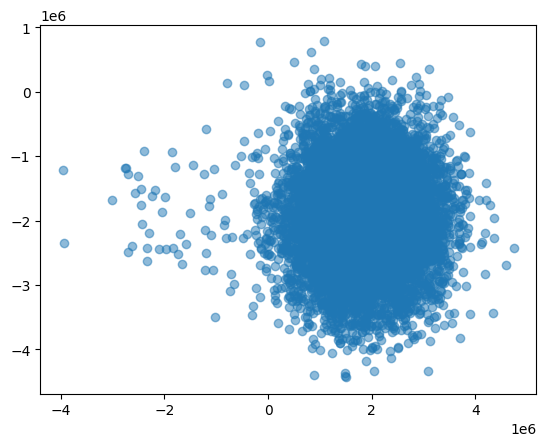

In [319]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

# Assuming data_2d is your dataset
data_2d = combined_data

# Plot the data points
plt.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5)

def draw_ellipse(mean, cov, n_std=1, ax=None, **kwargs):
    """Draw an ellipse with a given mean and covariance"""
    ax = ax or plt.gca()

    # Eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellipse)

# Number of standard deviations to draw
n_std = 2 

# Assuming gmm is your fitted GaussianMixture model
# Since covariance_type='tied', all components share the same covariance
shared_covariance = gmm.covariances_

# Plot each Gaussian component
for mean in gmm.means_:
    draw_ellipse(mean, shared_covariance, n_std=n_std, alpha=1, edgecolor='red', facecolor='none')

plt.title("Data and Fitted Gaussian Components")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.show()


# Other fiting methods

In [307]:
n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(combined_data)

print("means: ", gmm.means_)
print("covariances: ", gmm.covariances_)
print("weights: ", gmm.weights_)

means:  [[ 2016588.28839659 -2067617.44528235]
 [ 1633544.48483212 -1754031.3498254 ]]
covariances:  [[[3.64062001e+11 1.46816323e+10]
  [1.46816323e+10 4.69258318e+11]]

 [[7.30566530e+11 4.01136275e+10]
  [4.01136275e+10 5.00602431e+11]]]
weights:  [0.55046022 0.44953978]


In [229]:
import numpy as np
from sklearn.mixture import GaussianMixture

data = IQ_data.flatten()
combined_data = np.column_stack((data.real, data.imag))

positive_x_data = combined_data[combined_data[:, 0] > 0]
negative_x_data = combined_data[combined_data[:, 0] < 0]

mean_positive_x = np.mean(positive_x_data, axis=0)
mean_negative_x = np.mean(negative_x_data, axis=0)

means_init = np.array([mean_positive_x, mean_negative_x])
print(means_init)
weights_init = [0.03, 0.97]

n_components = 2
gmm = GaussianMixture(n_components=n_components, covariance_type='full', means_init=means_init, weights_init=weights_init)
gmm.fit(combined_data)

print("means: ", gmm.means_)
print("covariances: ", gmm.covariances_)
print("weights: ", gmm.weights_)

[[17703227.24161766 41708151.96915299]
 [-9408223.97394137 42226955.19218241]]
means:  [[17510178.72342988 41869221.03726113]
 [ 9322964.14905179 40010379.7098868 ]]
covariances:  [[[ 6.66241555e+13  1.17974035e+12]
  [ 1.17974035e+12  7.34459200e+13]]

 [[ 3.05007346e+14 -1.78276095e+13]
  [-1.78276095e+13  7.66235917e+13]]]
weights:  [0.92191813 0.07808187]


In [219]:
from sklearn.linear_model import RANSACRegressor

data = IQ_data.flatten()
combined_data = np.column_stack((data.real, data.imag))

ransac = RANSACRegressor()
ransac.fit(combined_data, np.zeros(combined_data.shape[0]))

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Estimate Gaussian parameters from inliers
mean_est = np.mean(combined_data[inlier_mask], axis=0)
cov_est = np.cov(combined_data[inlier_mask].T)

print("mean_est", mean_est)
print("cov_est", cov_est)

mean_est [-11997613.2711  16434506.364 ]
cov_est [[4.19742624e+13 1.16721728e+12]
 [1.16721728e+12 1.11869514e+13]]
